In [1]:
from fastai.vision.all import *
import fastai
import timm
import torch
import albumentations as A
transform = A.load("/media/newhd/OPTRetina/DMAE/autoalbument-amd/outputs/2021-11-24/10-32-22/policy/latest.json")

class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [2]:
torch.cuda.set_device(1)

In [3]:
df = pd.read_csv('../trainValid.csv')

In [4]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [5]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 224

In [6]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='inception_resnet_v2_244_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = db.dataloaders(df.values,bs=128,num_workers=0)

In [9]:
learn = Learner(dls,timm.create_model('inception_resnet_v2',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

SuggestedLRs(valley=0.00019054606673307717)

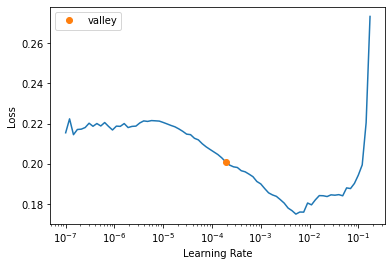

In [10]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.125817,0.262369,0.653846,0.604530,0.889744,0.719917,0.786216,01:57


Better model found at epoch 0 with f1_score value: 0.7199170124481328.


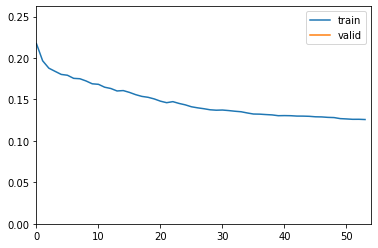

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.096713,0.092480,0.843590,0.882857,0.792308,0.835135,0.930947,01:59
1,0.090305,0.076349,0.865385,0.892562,0.830769,0.860558,0.948616,02:00
2,0.085686,0.080880,0.844872,0.883191,0.794872,0.836707,0.941387,02:00
3,0.083042,0.080094,0.842308,0.869806,0.805128,0.836218,0.942110,02:00
4,0.081051,0.081893,0.855128,0.896848,0.802564,0.847091,0.944109,01:59
5,0.077327,0.091407,0.837179,0.917460,0.741026,0.819858,0.937219,01:59
6,0.075108,0.075208,0.864103,0.875661,0.848718,0.861979,0.951203,01:59
7,0.074995,0.078832,0.856410,0.883978,0.820513,0.851064,0.945766,02:00
8,0.072446,0.082330,0.865385,0.894737,0.828205,0.860186,0.946686,02:00
9,0.072876,0.093804,0.835897,0.835897,0.835897,0.835897,0.926693,01:59


Better model found at epoch 0 with f1_score value: 0.8351351351351352.


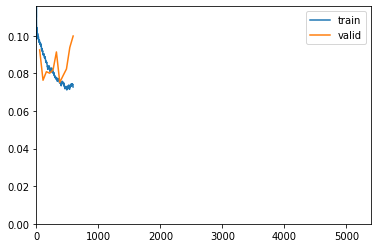

Better model found at epoch 1 with f1_score value: 0.8605577689243028.
Better model found at epoch 6 with f1_score value: 0.8619791666666666.
No improvement since epoch 6: early stopping


In [11]:
learn.fine_tune(100,base_lr=3e-3)

In [12]:
dfTest = pd.read_csv('../testSample.csv')

In [13]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [14]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [15]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [16]:
learn.dls = dlsTest

In [17]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9455179487179487.


(#6) [0.08224102109670639,0.8661538362503052,0.8672839506172839,0.8646153846153846,0.8659476117103235,0.9455179487179487]

# 384

In [18]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='inception_resnet_v2_384_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [19]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [20]:
dls = db.dataloaders(df.values,bs=32,num_workers=0)

In [21]:
learn = Learner(dls,timm.create_model('inception_resnet_v2',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [22]:
learn.load('inception_resnet_v2_244_b')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=0.0002290867705596611)

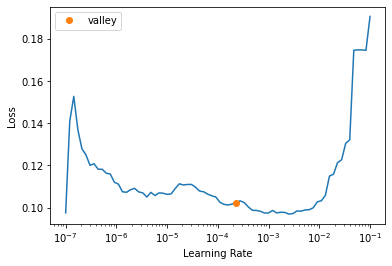

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.133227,0.246982,0.671795,0.643777,0.769231,0.700935,0.775302,03:06


Better model found at epoch 0 with f1_score value: 0.7009345794392524.


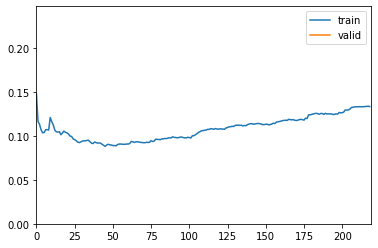

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.106577,0.105636,0.794872,0.883333,0.679487,0.768116,0.916936,03:05
1,0.096983,0.092918,0.832051,0.858726,0.794872,0.825566,0.924993,03:05
2,0.094848,0.089650,0.833333,0.845745,0.815385,0.830287,0.926926,03:04
3,0.087018,0.088290,0.847436,0.932907,0.748718,0.830725,0.938820,03:05
4,0.089821,0.081740,0.834615,0.867606,0.789744,0.826846,0.937873,03:05
5,0.090236,0.095477,0.823077,0.896226,0.730769,0.805085,0.931969,03:04
6,0.086598,0.085577,0.835897,0.848404,0.817949,0.832898,0.935480,03:02
7,0.086568,0.088080,0.861538,0.919643,0.792308,0.851240,0.941654,02:59
8,0.087345,0.087474,0.848718,0.871585,0.817949,0.843915,0.939592,02:59
9,0.092547,0.088931,0.867949,0.880637,0.851282,0.865711,0.934730,02:59


Better model found at epoch 0 with f1_score value: 0.7681159420289855.


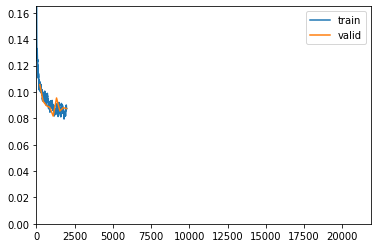

Better model found at epoch 1 with f1_score value: 0.825565912117177.
Better model found at epoch 2 with f1_score value: 0.8302872062663186.
Better model found at epoch 3 with f1_score value: 0.8307254623044096.
Better model found at epoch 6 with f1_score value: 0.8328981723237597.
Better model found at epoch 7 with f1_score value: 0.8512396694214877.
Better model found at epoch 9 with f1_score value: 0.8657105606258148.
No improvement since epoch 4: early stopping


In [23]:
learn.fine_tune(100,base_lr=3e-3)

In [24]:
dfTest = pd.read_csv('../testSample.csv')

In [25]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [26]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [27]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [28]:
learn.dls = dlsTest

In [29]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9590216962524655.


(#6) [0.07311046123504639,0.9051281809806824,0.9106029106029107,0.8984615384615384,0.9044914816726898,0.9590216962524655]

# 512

In [30]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='inception_resnet_v2_512_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [31]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [32]:
dls = db.dataloaders(df.values,bs=8,num_workers=0)

In [33]:
learn = Learner(dls,timm.create_model('inception_resnet_v2',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [34]:
learn.load('inception_resnet_v2_384_b')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=2.0892961401841603e-05)

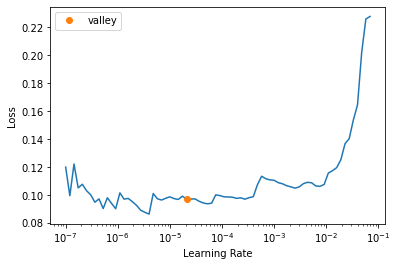

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.085895,0.088633,0.851282,0.893678,0.797436,0.842818,0.941956,06:40


Better model found at epoch 0 with f1_score value: 0.8428184281842819.


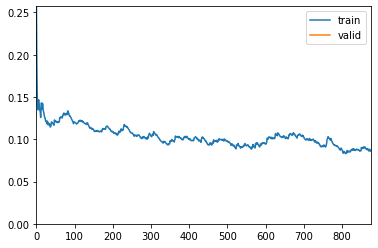

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.090234,0.086699,0.867949,0.904225,0.823077,0.861745,0.941262,06:38
1,0.083239,0.082223,0.864103,0.887978,0.833333,0.859788,0.944849,06:38
2,0.082425,0.082841,0.860256,0.893557,0.817949,0.854083,0.944412,06:38
3,0.087075,0.083235,0.865385,0.901408,0.820513,0.859060,0.945503,06:39
4,0.093026,0.078951,0.866667,0.892857,0.833333,0.862069,0.947554,06:39
5,0.086322,0.080324,0.885897,0.921569,0.843590,0.880857,0.950201,06:38
6,0.078724,0.084144,0.860256,0.902579,0.807692,0.852503,0.946571,06:39
7,0.078214,0.078372,0.866667,0.886486,0.841026,0.863158,0.948810,06:41
8,0.079589,0.089437,0.858974,0.897727,0.810256,0.851752,0.940654,06:40
9,0.076614,0.086006,0.857692,0.892958,0.812821,0.851007,0.942005,06:32


Better model found at epoch 0 with f1_score value: 0.8617449664429531.


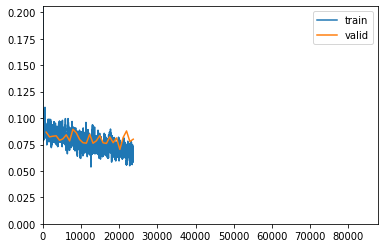

Better model found at epoch 4 with f1_score value: 0.8620689655172413.
Better model found at epoch 5 with f1_score value: 0.8808567603748326.
Better model found at epoch 22 with f1_score value: 0.8897338403041826.
No improvement since epoch 22: early stopping


In [35]:
learn.fine_tune(100,base_lr=1e-4)

In [36]:
dfTest = pd.read_csv('../testSample.csv')

In [37]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [38]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [39]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=8,num_workers=0)

In [40]:
learn.dls = dlsTest

In [41]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9672052596975674.


(#6) [0.0636846274137497,0.9061538577079773,0.9008097165991903,0.9128205128205128,0.9067753438614365,0.9672052596975674]